In [ ]:
from google.colab import drive #If you are working with google colab
drive.mount('/content/drive')

Mounted at /content/drive


Found 2145 images belonging to 2 classes.
Found 536 images belonging to 2 classes.
Found 1340 images belonging to 2 classes.
Found 1341 images belonging to 2 classes.
Scaler saved to /content/drive/MyDrive/Colab Notebooks/scaler_PMA.pkl
PCA saved to /content/drive/MyDrive/Colab Notebooks/pca_PMA.pkl
Model saved to /content/drive/MyDrive/Colab Notebooks/logistic_regression_model_PMA.pkl
Model loaded successfully
Classification Report:
                   precision    recall  f1-score   support

    NET_negative       0.93      0.94      0.94       663
NET_positive_pma       0.94      0.93      0.94       678

        accuracy                           0.94      1341
       macro avg       0.94      0.94      0.94      1341
    weighted avg       0.94      0.94      0.94      1341



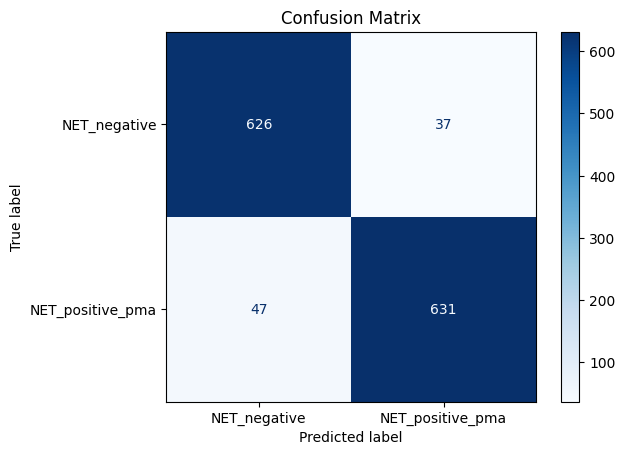

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Path to save all the files, change this accordingly

DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/new_data'
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/logistic_regression_model_PMA.pkl'  # Path to save the model
SCALER_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/scaler_PMA.pkl'
PCA_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/pca_PMA.pkl'
# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)
validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)
# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)
test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)
# Function to extract features and labels from the generator
def extract_features(generator):
    features = []
    labels = []
    batch_size = generator.batch_size
    num_batches = len(generator)
    for _ in range(num_batches):
        batch_features, batch_labels = next(generator)  # Use next(generator) to fetch the next batch
        batch_features = batch_features.reshape((batch_features.shape[0], -1))  # Flatten the images
        features.append(batch_features)
        labels.append(batch_labels)
    # Stack all batches together
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, np.argmax(labels, axis=1)
# Extract features and labels
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
X_test, y_test = extract_features(test_generator)
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
# Create and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"Scaler saved to {SCALER_SAVE_PATH}")
# Create and fit the PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
joblib.dump(pca, PCA_SAVE_PATH)
print(f"PCA saved to {PCA_SAVE_PATH}")

# Create a logistic regression model with L2 regularization
model = LogisticRegression(class_weight=class_weights, max_iter=1000, penalty='l2', C=1.0)

# Train the model
model.fit(X_train_pca, y_train)

# Save the trained model
joblib.dump(model, MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")
# Load the model (optional, for demonstration)

loaded_model = joblib.load(MODEL_SAVE_PATH)
print("Model loaded successfully")

# Evaluate the model
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred = loaded_model.predict(X_test_pca)

# Calculate precision, recall, F1 score
report = classification_report(y_test, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)
# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Prediction probabilities: [[0.03532464 0.96467536]]


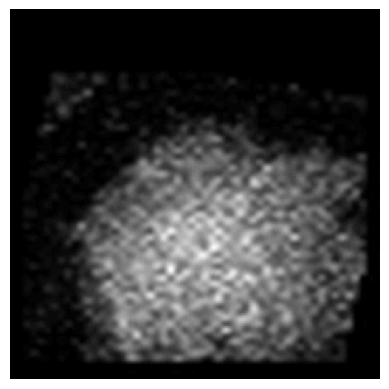

(1, array([[0.03532464, 0.96467536]]))

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import joblib
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime

# Load the trained logistic regression model, StandardScaler, and PCA
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/logistic_regression_model_PMA.pkl'  # Path to save the model
SCALER_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/scaler_PMA.pkl'
PCA_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/pca_PMA.pkl'
model = joblib.load(MODEL_SAVE_PATH)
scaler = joblib.load(SCALER_SAVE_PATH)
pca = joblib.load(PCA_SAVE_PATH)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
def predict_and_display_image(image_path, model, scaler, pca, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image
    # Apply StandardScaler and PCA
    img_array_scaled = scaler.transform(img_array)
    img_array_pca = pca.transform(img_array_scaled)
    # Make a prediction
    prediction_prob = model.predict_proba(img_array_pca)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]
    print(f"Prediction probabilities: {prediction_prob}")
    # Display the image
    plt.imshow(img_array.reshape(img_size), cmap='gray')
    plt.axis('off')
    plt.show()
    return predicted_class, prediction_prob
# Predict the class of a specific image from the test set
# Change: Dynamically generate the subimage path
subimage_path = '/content/drive/MyDrive/Colab Notebooks/data/new_data/NET_positive_pma/aug_3_20211111.lif_PMA 3.11.21NET488_MPO633_011.tif_sub_image_50.png'
predict_and_display_image(subimage_path, model, scaler, pca)